In [38]:
import sys
sys.path.append("../../")

from src.analysis.cointegration import find_cointegrated_pairs, analyze_pairs, plot_cointegration_heatmap
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
import statsmodels.api as sm

warnings.filterwarnings('ignore')

DATE_CONFIG = {
   'TRAIN_START': pd.Timestamp('2021-02-02'),
   'TRAIN_END': pd.Timestamp('2024-01-01'),  
   'TEST_END': pd.Timestamp('2025-01-01'),
   'TRADING_DAYS_PER_YEAR': 252  
}

def get_training_period():
    return {
        'start': DATE_CONFIG['TRAIN_START'],
        'end': DATE_CONFIG['TRAIN_END']
    }

def get_test_period():
    return {
        'start': DATE_CONFIG['TRAIN_END'],
        'end': DATE_CONFIG['TEST_END']
    }

def get_training_days():
    years = (DATE_CONFIG['TRAIN_END'] - DATE_CONFIG['TRAIN_START']).days / 365
    return int(years * DATE_CONFIG['TRADING_DAYS_PER_YEAR'])

# Plot settings
plt.style.use('classic')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [39]:
def load_and_prepare_data(file_path):

    df = pd.read_parquet(file_path)
    df['date'] = pd.to_datetime(df['date'])
    
    mask = (df['date'] >= DATE_CONFIG['TRAIN_START']) & \
           (df['date'] <= DATE_CONFIG['TEST_END'])
    df = df[mask]
    
    price_matrix = df.pivot(index='date', columns='symbol', values='close')
    
    symbols = price_matrix.columns.tolist()
    
    print(f"Loaded data from {DATE_CONFIG['TRAIN_START']} to {DATE_CONFIG['TEST_END']}")
    print(f"Total symbols: {len(symbols)}")
    print(f"Total trading days: {len(price_matrix)}")
    
    return price_matrix, symbols

In [40]:
import toml

with open("../config.toml", "r") as f:
    config = toml.load(f)
    
price_matrix, symbols = load_and_prepare_data(config['data']['raw_data_path'])

Loaded data from 2021-02-02 00:00:00 to 2025-01-01 00:00:00
Total symbols: 94
Total trading days: 985


Analyzing pairs: 100%|██████████| 4371/4371 [00:52<00:00, 83.98it/s]



Analysis complete!
Found 244 cointegrated pairs
Total pairs analyzed: 4371


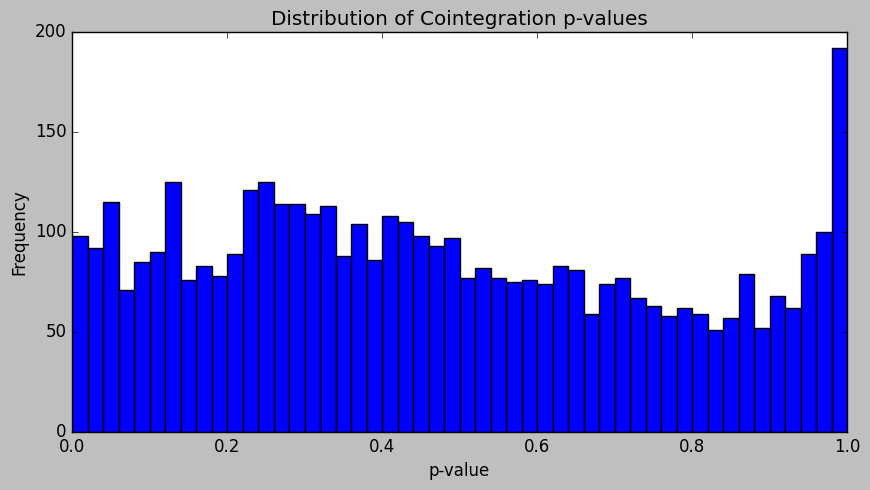

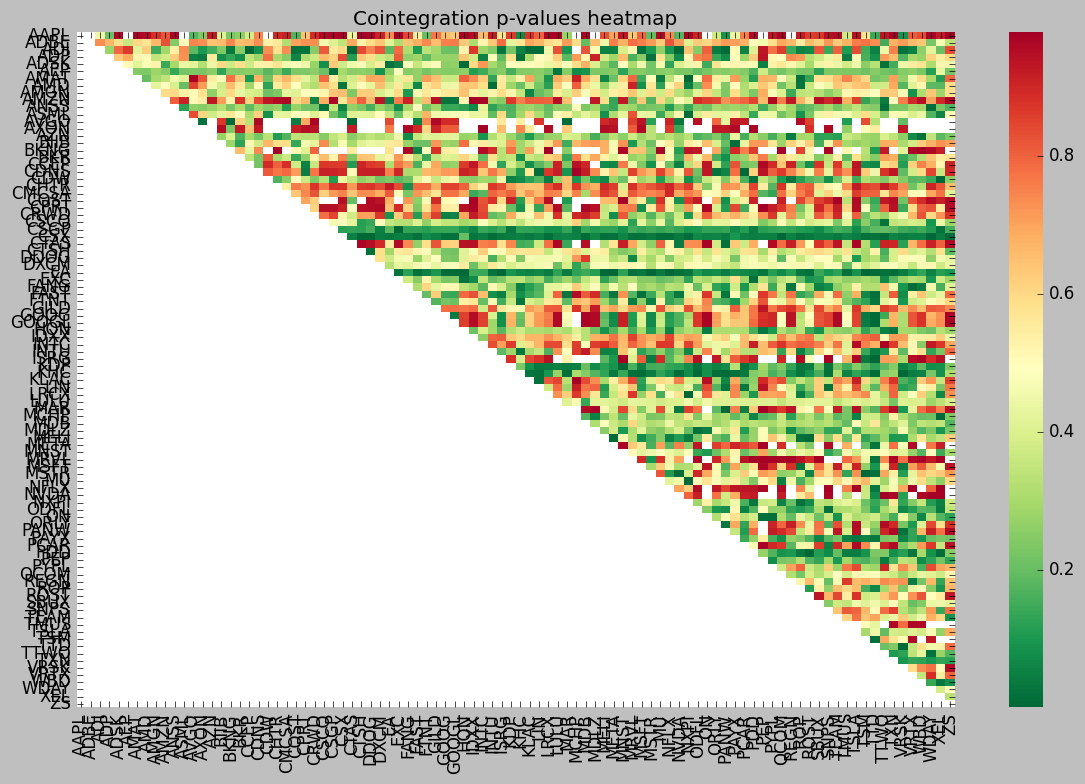

In [41]:
score_matrix, pvalue_matrix, pairs, summary_df = analyze_pairs(
    price_matrix,
    pvalue_threshold=0.05
)

plt.figure(figsize=(10, 5))
plt.hist(summary_df['p_value'], bins=50)
plt.title('Distribution of Cointegration p-values')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.show()

plot_cointegration_heatmap(pvalue_matrix, symbols)

In [42]:
def zscore(series):
    return (series - series.mean()) / np.std(series)

def calculate_spread(data, symbol1, symbol2, start_date=None, end_date=None):
    if start_date:
        mask = (data.index >= start_date) & (data.index <= end_date)
        data = data[mask]
    
    ratios = data[symbol1] / data[symbol2]
    zscore_ratios = zscore(ratios)
    
    return ratios, zscore_ratios

In [43]:
def get_top_pairs(price_matrix, train_start, train_end, symbols):
    # Nimm nur die ersten 70% der Train-Daten für Paarauswahl
    train_length = (train_end - train_start).days
    pair_selection_end = train_start + pd.Timedelta(days=int(train_length * 0.7))
    
    # Paarauswahl nur auf subset der Trainingsdaten
    selection_mask = (price_matrix.index >= train_start) & (price_matrix.index <= pair_selection_end)
    selection_data = price_matrix[selection_mask]
    
    # Initial Paarauswahl auf Selection Daten
    score_matrix, pvalue_matrix, pairs, summary_df = analyze_pairs(selection_data, pvalue_threshold=0.05)
    
    # Score Berechnung
    combined_scores = []
    for pair in pairs:
        idx1 = symbols.index(pair[0])
        idx2 = symbols.index(pair[1])
        sum_idx = summary_df[(summary_df['symbol1'] == pair[0]) & (summary_df['symbol2'] == pair[1])].index[0]
        score_value = score_matrix[idx1, idx2]
        p_value = summary_df.loc[sum_idx, 'p_value']
        combined_scores.append({
            'pair': pair,
            'score': -score_value * (1 - p_value)
        })

    sorted_pairs = sorted(combined_scores, key=lambda x: x['score'], reverse=True)
    return [x['pair'] for x in sorted_pairs[:20]]  # Top 20 Paare direkt zurückgeben

In [44]:
def trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2, window=20, std_dev=2):
    # Berechne hedge ratio aus Training Daten
    model = sm.OLS(S1_train, S2_train).fit()
    hedge_ratio = model.params[0]
    
    # Berechne Spread für Training und Test
    spread_train = S1_train - (S2_train * hedge_ratio)
    spread_test = S1_test - (S2_test * hedge_ratio)
    
    # Berechne initiale Bollinger Bands aus Training
    rolling_mean = spread_train.rolling(window=window).mean().iloc[-1]
    rolling_std = spread_train.rolling(window=window).std().iloc[-1]
    
    trades = []
    trade_id = 0
    position = 0
    entry_prices = None
    entry_date = None
    
    for i in range(len(spread_test)):
        current_date = spread_test.index[i]
        current_spread = spread_test.iloc[i]
        
        upper_band = rolling_mean + (rolling_std * std_dev)
        lower_band = rolling_mean - (rolling_std * std_dev)
        
        if position == 0:
            if current_spread < lower_band:
                entry_date = current_date
                entry_prices = {
                    symbol1: {"price": S1_test.iloc[i], "type": "long"},
                    symbol2: {"price": S2_test.iloc[i], "type": "short"}
                }
                position = 1
            elif current_spread > upper_band:
                entry_date = current_date
                entry_prices = {
                    symbol1: {"price": S1_test.iloc[i], "type": "short"},
                    symbol2: {"price": S2_test.iloc[i], "type": "long"}
                }
                position = -1
        elif position != 0 and abs(current_spread - rolling_mean) < (rolling_std * 0.5):
            for symbol in [symbol1, symbol2]:
                trades.append({
                    'trade_id': trade_id,
                    'symbol': symbol,
                    'entry_date': entry_date,
                    'entry_price': entry_prices[symbol]["price"],
                    'exit_date': current_date,
                    'exit_price': S1_test.iloc[i] if symbol == symbol1 else S2_test.iloc[i],
                    'position_type': entry_prices[symbol]["type"],
                    'paired_symbol': symbol2 if symbol == symbol1 else symbol1,
                    'exit_type': 'target'
                })
            position = 0
            trade_id += 1
            
    return trades

In [45]:
def backtest_pairs_rolling(price_matrix, symbols):
    all_trades = []
    test_start = DATE_CONFIG['TRAIN_END']
    months = pd.date_range(test_start, DATE_CONFIG['TEST_END'], freq='M')
    window_size = pd.DateOffset(months=1)
    
    print(f"Starting backtest from {test_start} to {DATE_CONFIG['TEST_END']}")
    print(f"Total months to test: {len(months)}")
    
    for i, month_end in enumerate(months):
        month_start = test_start + i * window_size
        train_start = DATE_CONFIG['TRAIN_START'] + i * window_size
        train_end = test_start + i * window_size
        
        print(f"\nMonth {i+1}:")
        print(f"Training period: {train_start} to {train_end}")
        print(f"Test period: {month_start} to {month_end}")
        
        top_pairs = get_top_pairs(price_matrix, train_start, train_end, symbols)
        print(f"Found {len(top_pairs)} validated pairs")
        
        trades_this_month = 0
        for symbol1, symbol2 in top_pairs:
            training_mask = (price_matrix.index >= train_start) & (price_matrix.index < train_end)
            test_mask = (price_matrix.index >= month_start) & (price_matrix.index < month_end)
            
            S1_train = price_matrix[symbol1][training_mask]
            S2_train = price_matrix[symbol2][training_mask]
            S1_test = price_matrix[symbol1][test_mask]
            S2_test = price_matrix[symbol2][test_mask]
            
            if not S1_test.empty and not S2_test.empty:
                pair_trades = trade(S1_train, S2_train, S1_test, S2_test, symbol1, symbol2)
                trades_this_month += len(pair_trades)
                all_trades.extend(pair_trades)
        
        print(f"Made {trades_this_month} trades this month")
    
    print(f"\nTotal trades: {len(all_trades)}")
    trades_df = pd.DataFrame(all_trades)
    trades_df.to_parquet('../../data/results/CoInt_Bollinger.parquet')
    return trades_df

In [46]:
trades_df = backtest_pairs_rolling(price_matrix, symbols)

Starting backtest from 2024-01-01 00:00:00 to 2025-01-01 00:00:00
Total months to test: 12

Month 1:
Training period: 2021-02-02 00:00:00 to 2024-01-01 00:00:00
Test period: 2024-01-01 00:00:00 to 2024-01-31 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 185.66it/s]



Analysis complete!
Found 276 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 14 trades this month

Month 2:
Training period: 2021-03-02 00:00:00 to 2024-02-01 00:00:00
Test period: 2024-02-01 00:00:00 to 2024-02-29 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 184.71it/s]



Analysis complete!
Found 307 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 6 trades this month

Month 3:
Training period: 2021-04-02 00:00:00 to 2024-03-01 00:00:00
Test period: 2024-03-01 00:00:00 to 2024-03-31 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 187.89it/s]



Analysis complete!
Found 265 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 12 trades this month

Month 4:
Training period: 2021-05-02 00:00:00 to 2024-04-01 00:00:00
Test period: 2024-04-01 00:00:00 to 2024-04-30 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 187.66it/s]



Analysis complete!
Found 193 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 12 trades this month

Month 5:
Training period: 2021-06-02 00:00:00 to 2024-05-01 00:00:00
Test period: 2024-05-01 00:00:00 to 2024-05-31 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 189.88it/s]



Analysis complete!
Found 283 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 8 trades this month

Month 6:
Training period: 2021-07-02 00:00:00 to 2024-06-01 00:00:00
Test period: 2024-06-01 00:00:00 to 2024-06-30 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 187.53it/s]



Analysis complete!
Found 228 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 8 trades this month

Month 7:
Training period: 2021-08-02 00:00:00 to 2024-07-01 00:00:00
Test period: 2024-07-01 00:00:00 to 2024-07-31 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 188.76it/s]



Analysis complete!
Found 259 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 18 trades this month

Month 8:
Training period: 2021-09-02 00:00:00 to 2024-08-01 00:00:00
Test period: 2024-08-01 00:00:00 to 2024-08-31 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 188.42it/s]



Analysis complete!
Found 332 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 6 trades this month

Month 9:
Training period: 2021-10-02 00:00:00 to 2024-09-01 00:00:00
Test period: 2024-09-01 00:00:00 to 2024-09-30 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:22<00:00, 190.97it/s]



Analysis complete!
Found 298 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 14 trades this month

Month 10:
Training period: 2021-11-02 00:00:00 to 2024-10-01 00:00:00
Test period: 2024-10-01 00:00:00 to 2024-10-31 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:22<00:00, 191.68it/s]



Analysis complete!
Found 371 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 6 trades this month

Month 11:
Training period: 2021-12-02 00:00:00 to 2024-11-01 00:00:00
Test period: 2024-11-01 00:00:00 to 2024-11-30 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:22<00:00, 191.80it/s]



Analysis complete!
Found 266 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 16 trades this month

Month 12:
Training period: 2022-01-02 00:00:00 to 2024-12-01 00:00:00
Test period: 2024-12-01 00:00:00 to 2024-12-31 00:00:00


Analyzing pairs: 100%|██████████| 4371/4371 [00:23<00:00, 186.79it/s]



Analysis complete!
Found 501 cointegrated pairs
Total pairs analyzed: 4371
Found 20 validated pairs
Made 12 trades this month

Total trades: 132
